# Text Mining: Course introduction

This course uses [Jupyter notebooks](http://jupyter.org/) for the lab assignments. Notebooks let you write and execute Python code in a web browser, and they make it very easy to mix code and text.

The purpose of this particular notebook is to give you a glimpse of what is to come.

## Load some data

Load a data set of movie reviews.

In [1]:
import bz2
import pandas as pd

with bz2.open('sst-train.json.bz2', 't') as source:
    df = pd.read_json(source)

Print the number of reviews.

In [2]:
len(df)

6920

Show the first few reviews.

In [3]:
df.head()

,text,polarity
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Singer/composer Bryan Adams contributes a slew...,1
3,Yet the act is still charming here .,1
4,Whether or not you 're enlightened by any of D...,1


Define a helper function that splits a text into tokens at whitespace and removes any non-alphabetic tokens.

In [4]:
def tokens(text):
    return [t.lower() for t in text.split() if t.isalpha()]

## Exploration 1: Basic statistics

Load the `Counter` class, which is useful for statistics.

In [5]:
from collections import Counter

Count how many occurrences of each token (word) the data contains.

In [6]:
counter = Counter()
for text in df['text']:
    counter.update(tokens(text))

Print the total number of tokens.

In [7]:
print(len(counter))

13241


The token *movie* occurs quite often:

In [8]:
print(counter['movie'])

808


Print the 10 most common words.

In [9]:
counter.most_common(10)

[('the', 5954),
 ('a', 4361),
 ('and', 3831),
 ('of', 3631),
 ('to', 2438),
 ('is', 2096),
 ('it', 1949),
 ('that', 1612),
 ('in', 1556),
 ('as', 1074)]

Plot the number of occurrences of the 100 most common words.

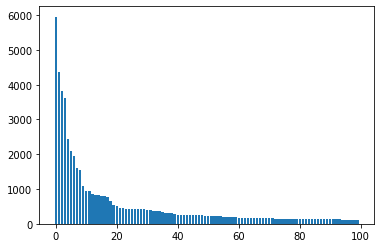

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

labels, values = zip(*counter.most_common(100))
plt.bar(range(len(labels)), values)
plt.show()

## Exploration 2: Information extraction

Load spaCy.

In [11]:
import spacy

Load the English language model.

In [12]:
nlp = spacy.load('en_core_web_sm')

Define a short text.

In [13]:
text = u'Apple Corp. buys Alphabet Inc. for $1 billion'

Process the text using the default pipeline.

In [14]:
doc = nlp(text)

Print the tokens together with their lemmas, part-of-speech tags, and stopword flags.

In [15]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.is_stop)

Apple Apple PROPN False
Corp. Corp. PROPN False
buys buy VERB False
Alphabet Alphabet PROPN False
Inc. Inc. PROPN False
for for ADP True
$ $ SYM False
1 1 NUM False
billion billion NUM False


Show the dependency parse.

In [16]:
from spacy import displacy

displacy.render(doc, style='dep', options={'distance': 110}, jupyter=True)

Show the named entities.

In [17]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

The following function will find the root word of an entity.

In [18]:
def root(ent):
    for token in ent:
        while not token.head is token and ent.start <= token.head.i and token.head.i < ent.end:
            token = token.head
        return token

Extract semantic relations.

In [19]:
for ent1 in doc.ents:
    root1 = root(ent1)
    for ent2 in doc.ents:
        root2 = root(ent2)
        if root1.head == root2.head and root1.head.pos_ == 'VERB' and root1.dep_ == 'nsubj' and root2.dep_ == 'dobj':
            print('[{}]-[{}]-[{}]'.format(ent1, root1.head.lemma_, ent2))

[Apple Corp.]-[buy]-[Alphabet Inc.]


## Exploration 3: Topic modelling

Import gensim.

In [20]:
import gensim

Disable some warnings.

In [21]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

Build the vocabulary and show its size.

In [22]:
dictionary = gensim.corpora.Dictionary(tokens(text) for text in df['text'])
len(dictionary)

13241

Filter out stop words, as well as extremely frequent/infrequent words.

In [23]:
bad_ids = [i for t, i in dictionary.token2id.items() if nlp.vocab[t].is_stop]
dictionary.filter_tokens(bad_ids=bad_ids)
dictionary.filter_extremes()
len(dictionary)

2543

Create an iterator over the data (for efficiency).

In [24]:
class MyCorpus(object):
    def __iter__(self):
        for text in df['text']:
            yield dictionary.doc2bow(tokens(text))

Build the LDA model (takes a while).

In [25]:
lda = gensim.models.ldamodel.LdaModel(
    corpus=MyCorpus(),
    num_topics=7,
    id2word=dictionary,
    chunksize=5,
    passes=10,
    update_every=1,
    alpha='auto',
)

Print the most common topics.

In [26]:
lda.print_topics(7)

[(0,
  '0.100*"comedy" + 0.055*"fun" + 0.027*"good" + 0.026*"romantic" + 0.020*"experience" + 0.019*"lot" + 0.018*"action" + 0.018*"fans" + 0.017*"great" + 0.016*"dialogue"'),
 (1,
  '0.057*"thriller" + 0.042*"director" + 0.040*"drama" + 0.032*"seen" + 0.023*"away" + 0.020*"charm" + 0.018*"lacks" + 0.017*"old" + 0.016*"awful" + 0.014*"come"'),
 (2,
  '0.035*"story" + 0.034*"characters" + 0.026*"feels" + 0.016*"movies" + 0.016*"case" + 0.016*"mind" + 0.015*"sequel" + 0.012*"look" + 0.012*"heart" + 0.012*"mystery"'),
 (3,
  '0.049*"like" + 0.047*"bad" + 0.027*"plot" + 0.020*"script" + 0.018*"opportunity" + 0.017*"character" + 0.015*"real" + 0.015*"cinematic" + 0.014*"long" + 0.014*"storytelling"'),
 (4,
  '0.033*"documentary" + 0.026*"dull" + 0.025*"fresh" + 0.016*"weird" + 0.015*"world" + 0.015*"predictable" + 0.015*"words" + 0.014*"romance" + 0.013*"family" + 0.013*"picture"'),
 (5,
  '0.082*"film" + 0.073*"movie" + 0.024*"funny" + 0.016*"little" + 0.013*"way" + 0.010*"makes" + 0.010*"

Load the pyLDAvis library for data visualization.

In [27]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

ModuleNotFoundError: No module named 'pyLDAvis'

Visualize the LDA model.

In [ ]:
pyLDAvis.gensim.prepare(lda, list(MyCorpus()), dictionary, mds='tsne')

That&rsquo;s all, folks!